# **Predicting User Churn for an E-commerce Platform**
*   Predict which users are most likely to churn.
*   Provide insights on the why behind their churn, focusing on actionable business takeaways.




## **Import the required libraries and data**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = r"/content/drive/MyDrive/events.csv"

In [ ]:
data = pd.read_csv(data_path)
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [ ]:
# Convert time object to datetime dtype
data['event_time'] = pd.to_datetime(data['event_time'])
data = data.drop(columns=['user_session'])
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344


In [ ]:
# Extract unique values from events
data['event_type'].unique()

array(['view', 'cart', 'purchase'], dtype=object)

## **Clean the data**

In [ ]:
# Check null values
data.isnull().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,236219
brand,212364
price,0
user_id,0


In [ ]:
# Fill null values with 'Unknown'

data['brand'].fillna('Unknown', inplace=True)
data['category_code'].fillna('Other', inplace=True)
data.isnull().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,0
brand,0
price,0
user_id,0


In [ ]:
# Checking for duplicated rows
data.duplicated().sum()

837

In [ ]:
# Drop Duplicated rows
data = data.drop_duplicates()

## **Feature Engineering**

This code creates a new DataFrame `user_activity` by copying the original data DataFrame. It then calculates the total number of purchases made by each user `user_id` by grouping the data and transforming the `event_type` column. Specifically, it counts how many times the `event_type` is equal to 'purchase' for each user. Finally, it displays the first few rows of the resulting DataFrame using `.head()`.

In [ ]:
# Create a copy of the original data to avoid modifying it directly
user_activity = data.copy()

# Calculate the number of purchases for each user
# Group by 'user_id' and count occurrences of 'purchase' in the 'event_type' column
user_activity['number_of_purchases'] = data.groupby('user_id')['event_type'].transform(
    lambda x: (x == 'purchase').sum()  # Sum the boolean values (True = 1, False = 0)
)

# Display the first few rows of the updated DataFrame
user_activity.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,number_of_purchases
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,Unknown,31.90,1515915625519388267,0
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,0
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,Other,Unknown,9.81,1515915625513238515,0
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,0
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,Other,cameronsino,15.87,1515915625510743344,0


1. Summarize user behavior by calculating key metrics for each user:

- Engagement: How often a user views products `total_views`.
- Intent: How often a user adds products to their cart `total_carts`.
- Conversion: How often a user makes a purchase `total_purchases`.

2. Calculates two key metrics that help analyze user behavior:

 `cart_to_view_ratio` :
- Measures how effectively users are converting views into cart additions.
- A low ratio may indicate that users are not finding the products appealing or that the "Add to Cart" process is not user-friendly.

 `purchase_to_cart_ratio` :
- Measures how effectively users are converting cart additions into purchases.
- A low ratio may indicate issues with the checkout process, such as high shipping costs or a complicated payment process.

In [ ]:
# Group the 'user_activity' DataFrame by 'user_id' and aggregate the 'event_type' column
user_behavior = user_activity.groupby('user_id').agg(
    total_views=('event_type', lambda x: (x == 'view').sum()),  # Count the number of 'view' events for each user
    total_carts=('event_type', lambda x: (x == 'cart').sum()),  # Count the number of 'cart' events for each user
    total_purchases=('event_type', lambda x: (x == 'purchase').sum())  # Count the number of 'purchase' events for each user
).reset_index()  # Reset the index to make 'user_id' a column again

In [ ]:
# Calculate ratios
user_behavior['cart_to_view_ratio'] = user_behavior['total_carts'] / user_behavior['total_views']
user_behavior['purchase_to_cart_ratio'] = user_behavior['total_purchases'] / user_behavior['total_carts']

# Replace NaN with 0 (or another value)
user_behavior['cart_to_view_ratio'].fillna(0, inplace=True)
user_behavior['purchase_to_cart_ratio'].fillna(0, inplace=True)

This code normalizes the `user_id` column by replacing long or complex user IDs with simpler, sequential integers.

This is useful for Simplification -- Easier to work with and visualize data when user IDs are simple integers.

In [ ]:
# Step 1: Extract unique user IDs from the 'user_behavior' DataFrame
unique_user_ids = user_behavior['user_id'].unique()

# Step 2: Create a mapping from original user IDs to normalized IDs (starting from 1)
user_id_mapping = {user_id: idx + 1 for idx, user_id in enumerate(unique_user_ids)}

# Step 3: Apply the mapping to the 'user_id' column in the DataFrame
user_behavior['user_id'] = user_behavior['user_id'].map(user_id_mapping)

user_behavior.head(30)

,user_id,total_views,total_carts,total_purchases,cart_to_view_ratio,purchase_to_cart_ratio
0,1,1,0,0,0.00,0.0
1,2,1,0,0,0.00,0.0
2,3,13,0,0,0.00,0.0
3,4,1,0,0,0.00,0.0
4,5,36,0,0,0.00,0.0
5,6,4,0,0,0.00,0.0
6,7,1,0,0,0.00,0.0
7,8,1,0,0,0.00,0.0
8,9,1,0,0,0.00,0.0
9,10,8,2,1,0.25,0.5


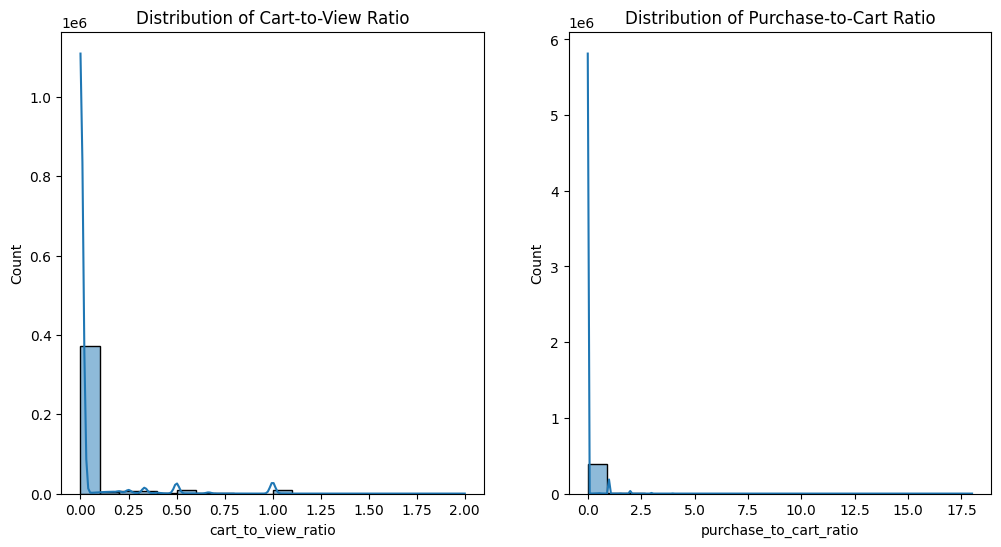

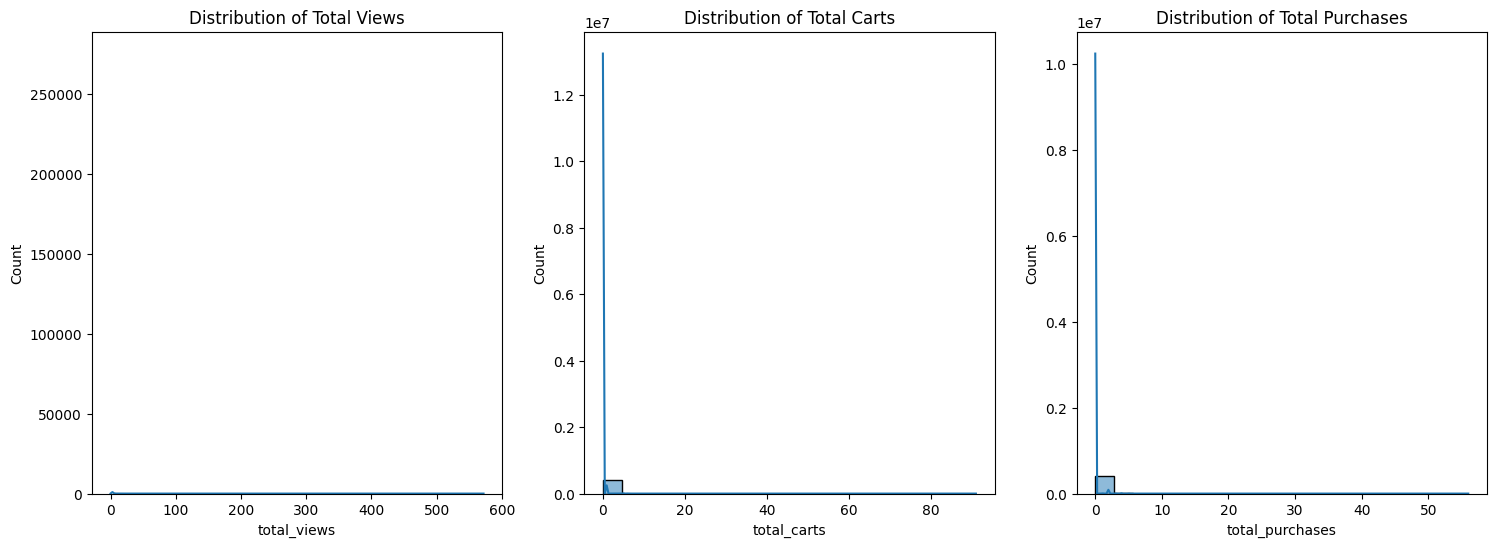

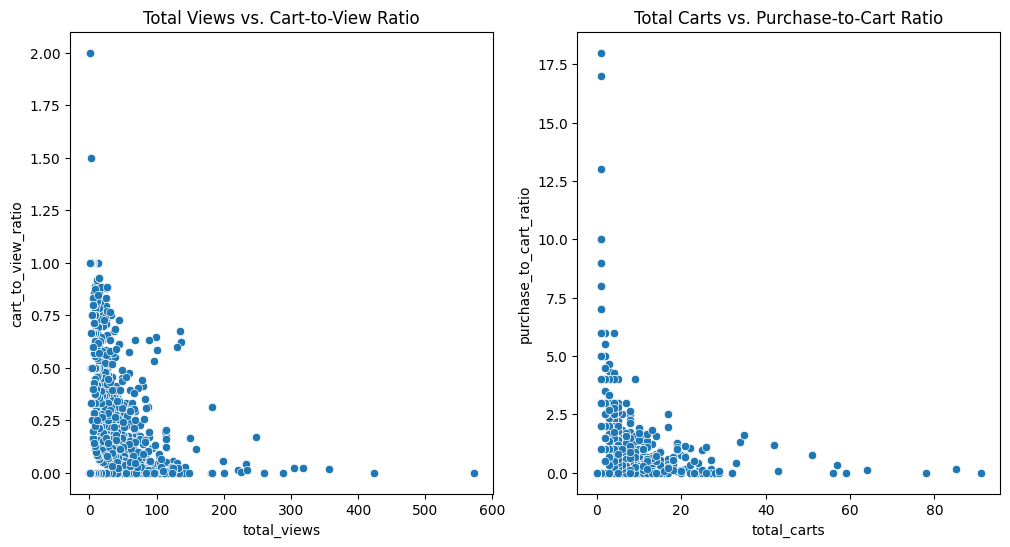

In [ ]:
# Visualize ratios
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(user_behavior['cart_to_view_ratio'], kde=True)
plt.title('Distribution of Cart-to-View Ratio')

plt.subplot(1, 2, 2)
sns.histplot(user_behavior['purchase_to_cart_ratio'], kde=True)
plt.title('Distribution of Purchase-to-Cart Ratio')
plt.show()


# Visualize totals
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(user_behavior['total_views'], kde=True)
plt.title('Distribution of Total Views')

plt.subplot(1, 3, 2)
sns.histplot(user_behavior['total_carts'], kde=True)
plt.title('Distribution of Total Carts')

plt.subplot(1, 3, 3)
sns.histplot(user_behavior['total_purchases'], kde=True)
plt.title('Distribution of Total Purchases')
plt.show()


# Scatter plots to visualize relationships between totals and ratios
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='total_views', y='cart_to_view_ratio', data=user_behavior)
plt.title('Total Views vs. Cart-to-View Ratio')

plt.subplot(1, 2, 2)
sns.scatterplot(x='total_carts', y='purchase_to_cart_ratio', data=user_behavior)
plt.title('Total Carts vs. Purchase-to-Cart Ratio')
plt.show()

## **Churn Analysis Report**

Based on the provided visualizations, we can derive insights into user behavior and identify potential reasons for churn. Below is a detailed analysis of the visualizations, along with actionable business takeaways to reduce churn.

---

## **1. Distribution of Total Views, Carts, and Purchases**

### **Key Observations**:
- **Total Views**:
  - The distribution is highly skewed, with most users having fewer than 100 views.
  - A small number of users have a very high number of views (outliers).

- **Total Carts**:
  - The majority of users have fewer than 10 carts.
  - A few users have a significantly higher number of carts.

- **Total Purchases**:
  - Most users have fewer than 5 purchases.
  - Very few users have more than 10 purchases.

### **Insights**:
- **Low Engagement**: Most users are not engaging deeply with the platform, as indicated by the low number of views, carts, and purchases.
- **High Churn Risk**: Users with low engagement (few views, carts, or purchases) are more likely to churn.
- **Loyal Users**: A small subset of users with high engagement (many views, carts, or purchases) represents loyal customers who should be targeted for retention.

### **Actionable Takeaways**:
- **Increase Engagement**:
  - Implement personalized product recommendations to encourage more views.
  - Use targeted marketing campaigns to re-engage users with low activity.

- **Retain Loyal Users**:
  - Offer loyalty programs or exclusive discounts to users with high engagement.
  - Provide personalized offers to encourage repeat purchases.

---

## **2. Total Views vs. Cart-to-View Ratio**

### **Key Observations**:
- **Low Cart-to-View Ratio**:
  - Many users have a low cart-to-view ratio, indicating that they view products but do not add them to their carts.

- **High Cart-to-View Ratio**:
  - A small number of users have a high cart-to-view ratio, indicating that they frequently add products to their carts after viewing.

### **Insights**:
- **Barriers to Cart Addition**:
  - Users may find the products unappealing or too expensive.
  - The "Add to Cart" button might be hard to find or the process might be cumbersome.

- **High-Intent Users**:
  - Users with a high cart-to-view ratio have a strong intent to purchase and should be targeted with incentives.

### **Actionable Takeaways**:
- **Optimize Product Pages**:
  - Improve product descriptions, images, and reviews to make products more appealing.
  - Make the "Add to Cart" button more prominent and user-friendly.

- **Target High-Intent Users**:
  - Offer discounts or free shipping to users who frequently add items to their carts.
  - Use retargeting ads to remind users of their abandoned carts.

---

## **3. Total Carts vs. Purchase-to-Cart Ratio**

### **Key Observations**:
- **Low Purchase-to-Cart Ratio**:
  - Many users have a low purchase-to-cart ratio, indicating that they add items to their carts but do not complete the purchase.

- **High Purchase-to-Cart Ratio**:
  - A small number of users have a high purchase-to-cart ratio, indicating that they frequently complete purchases after adding items to their carts.

### **Insights**:
- **Barriers to Purchase**:
  - Users may abandon their carts due to high shipping costs, a complicated checkout process, or lack of trust in the website.

- **High-Conversion Users**:
  - Users with a high purchase-to-cart ratio are likely to be loyal customers who should be targeted for retention.

### **Actionable Takeaways**:
- **Simplify the Checkout Process**:
  - Reduce the number of steps required to complete a purchase.
  - Offer guest checkout options to avoid forcing users to create an account.

- **Offer Incentives**:
  - Provide discounts or free shipping for users who abandon their carts.
  - Use email marketing to remind users of their abandoned carts.

---

## **4. Distribution of Cart-to-View Ratio and Purchase-to-Cart Ratio**

### **Key Observations**:
- **Cart-to-View Ratio**:
  - Most users have a cart-to-view ratio close to 0, indicating low conversion from views to carts.

- **Purchase-to-Cart Ratio**:
  - Most users have a purchase-to-cart ratio close to 0, indicating low conversion from carts to purchases.

### **Insights**:
- **Low Conversion Rates**:
  - The low conversion rates suggest that users are not finding the products appealing or are facing barriers during the checkout process.

- **High Churn Risk**:
  - Users with low conversion rates are more likely to churn.

### **Actionable Takeaways**:
- **Improve Product Recommendations**:
  - Use machine learning algorithms to provide personalized product recommendations based on user behavior.
  - Highlight best-selling or highly-rated products to reduce decision paralysis.

- **Optimize Pricing and Shipping**:
  - Conduct A/B testing to find the optimal price points for products.
  - Offer free or discounted shipping thresholds to encourage purchases.

---

## **5. Distribution of User IDs**

### **Key Observations**:
- **User ID Distribution**:
  - The distribution of user IDs is uniform, indicating that the dataset includes a wide range of users.

### **Insights**:
- **Diverse User Base**:
  - The dataset includes users with varying levels of engagement, from low to high.

### **Actionable Takeaways**:
- **Segment Users**:
  - Segment users based on their behavior (e.g., frequent buyers, window shoppers) and develop targeted strategies for each segment.
  - Use clustering algorithms to identify distinct user segments.

---

## **Conclusion**

The visualizations reveal that most users have low engagement and low conversion rates, which are key indicators of churn. To reduce churn, the business should focus on:

1. **Increasing Engagement**:
   - Implement personalized product recommendations and targeted marketing campaigns.

2. **Improving Conversion Rates**:
   - Optimize product pages, simplify the checkout process, and offer incentives for cart abandonment.

3. **Retaining Loyal Users**:
   - Offer loyalty programs, exclusive discounts, and personalized offers to high-engagement users.

By addressing these areas, the business can reduce churn and increase customer retention.

### **Prepare the data for Modeling**

This code creates a copy of the `user_activity` DataFrame called `modeling_data` for further analysis. It then calculates whether a user has churned based on their activity. A user is considered churned if their last activity `event_time` is more than 30 days ago compared to the most recent activity in the dataset `last_date`. The result is stored in a new column `churned`, where 1 indicates churned and 0 indicates active. Finally, the first few rows of the updated `modeling_data` DataFrame are displayed.

In [ ]:
# Create a copy of user_activity for modeling
modeling_data = user_activity.copy()

# Define churn: user is churned if last activity was more than 30 days ago
churn_period = pd.Timedelta(days=30)
last_date = data['event_time'].max()
modeling_data['churned'] = ((last_date - modeling_data['event_time']) > churn_period).astype(int)

modeling_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,number_of_purchases,churned
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,Unknown,31.90,1515915625519388267,0,1
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,0,1
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,Other,Unknown,9.81,1515915625513238515,0,1
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,0,1
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,Other,cameronsino,15.87,1515915625510743344,0,1


This code converts several columns in the `modeling_data` DataFrame to the Categorical data type using `pd.Categorical()`. Converting these columns to categorical is beneficial for memory efficiency and performance, especially when the columns contain a limited number of unique values (e.g., `event_type`, `category_id`, `product_id`, `category_code`, `brand`, and `churned`). This step is often done to optimize datasets for modeling or analysis.

In [ ]:
# Convert columns to categorical data type for efficient storage and processing
modeling_data['event_type'] = pd.Categorical(modeling_data['event_type'])
modeling_data['category_id'] = pd.Categorical(modeling_data['category_id'])
modeling_data['product_id'] = pd.Categorical(modeling_data['product_id'])
modeling_data['category_code'] = pd.Categorical(modeling_data['category_code'])
modeling_data['brand'] = pd.Categorical(modeling_data['brand'])
modeling_data['churned'] = pd.Categorical(modeling_data['churned'])

In [ ]:
# Print data types for modeling_data
modeling_data.dtypes

,0
event_time,"datetime64[ns, UTC]"
event_type,category
product_id,category
category_id,category
category_code,category
brand,category
price,float64
user_id,int64
number_of_purchases,int64
churned,category


This code performs the following steps:

1. Extracts temporal features from the `event_time` column:
- `event_year`: The year of the event.
- `event_month`: The month of the event.
- `event_day`: The day of the event.
- `event_hour`: The hour of the event.

2. Drops the original `event_time` column using `drop()` with `axis=1` (to drop a column) and `inplace=True` (to modify the DataFrame in place).

This transformation is useful for breaking down timestamp data into more granular features, which can be helpful for time-based analysis or modeling. After this step, the `event_time` column is removed, and the DataFrame now includes separate columns for year, month, day, and hour.

In [ ]:
# Extract year, month, day, and hour from the 'event_time' column
modeling_data['event_year'] = modeling_data['event_time'].dt.year
modeling_data['event_month'] = modeling_data['event_time'].dt.month
modeling_data['event_day'] = modeling_data['event_time'].dt.day
modeling_data['event_hour'] = modeling_data['event_time'].dt.hour

# Drop the original 'event_time' column as it's no longer needed
modeling_data.drop('event_time', axis=1, inplace=True)

modeling_data.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,number_of_purchases,churned,event_year,event_month,event_day,event_hour
0,view,1996170,2144415922528452715,electronics.telephone,Unknown,31.90,1515915625519388267,0,1,2020,9,24,11
1,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,0,1,2020,9,24,11
2,view,215454,2144415927158964449,Other,Unknown,9.81,1515915625513238515,0,1,2020,9,24,11
3,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,0,1,2020,9,24,11
4,view,3658723,2144415921169498184,Other,cameronsino,15.87,1515915625510743344,0,1,2020,9,24,11


This code performs frequency encoding on several categorical columns in the `modeling_data` DataFrame:

1. Frequency Encoding:
- For each categorical column `event_type, product_id, brand, category_code, category_id` , the code replaces the categorical values with their normalized frequency (i.e., the proportion of each value in the dataset).
- This is done using `.value_counts(normalize=True)`, which calculates the relative frequency of each unique value, and `.map()`, which maps these frequencies back to the original column.

2. Result:
- The categorical columns are now represented by numerical values that reflect how frequently each category appears in the dataset.
- This encoding can be useful for machine learning models, as it captures the importance or prevalence of each category without expanding the feature space (as in one-hot encoding).

Finally, the first few rows of the updated `modeling_data` DataFrame are displayed using `.head()` to show the transformed data.

In [ ]:
# Frequency Encoding: Replace categorical values with their normalized frequency
modeling_data['event_type'] = modeling_data['event_type'].map(modeling_data['event_type'].value_counts(normalize=True))
modeling_data['product_id'] = modeling_data['product_id'].map(modeling_data['product_id'].value_counts(normalize=True))
modeling_data['brand'] = modeling_data['brand'].map(modeling_data['brand'].value_counts(normalize=True))
modeling_data['category_code'] = modeling_data['category_code'].map(modeling_data['category_code'].value_counts(normalize=True))
modeling_data['category_id'] = modeling_data['category_id'].map(modeling_data['category_id'].value_counts(normalize=True))

# Display the first few rows of the updated DataFrame
modeling_data.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,number_of_purchases,churned,event_year,event_month,event_day,event_hour
0,0.896669,0.000002,0.041280,0.095327,0.239961,31.90,1515915625519388267,0,1,2020,9,24,11
1,0.896669,0.000008,0.011256,0.011256,0.004770,17.16,1515915625519380411,0,1,2020,9,24,11
2,0.896669,0.000607,0.011478,0.266899,0.239961,9.81,1515915625513238515,0,1,2020,9,24,11
3,0.896669,0.000340,0.029056,0.048838,0.003976,113.81,1515915625519014356,0,1,2020,9,24,11
4,0.896669,0.000001,0.023473,0.266899,0.006345,15.87,1515915625510743344,0,1,2020,9,24,11


In [ ]:
# Drop UserID column from modeling_data
modeling_data.drop(columns=['user_id'], inplace= True)
modeling_data.head()

,event_type,product_id,category_id,category_code,brand,price,number_of_purchases,churned,event_year,event_month,event_day,event_hour
0,0.896669,0.000002,0.041280,0.095327,0.239961,31.90,0,1,2020,9,24,11
1,0.896669,0.000008,0.011256,0.011256,0.004770,17.16,0,1,2020,9,24,11
2,0.896669,0.000607,0.011478,0.266899,0.239961,9.81,0,1,2020,9,24,11
3,0.896669,0.000340,0.029056,0.048838,0.003976,113.81,0,1,2020,9,24,11
4,0.896669,0.000001,0.023473,0.266899,0.006345,15.87,0,1,2020,9,24,11


This code standardizes selected numerical columns `(number_of_purchases, price, event_year, event_month, event_day, event_hour)` in the `modeling_data` DataFrame using `StandardScaler`, which transforms the data to have a mean of 0 and a standard deviation of 1. This step ensures that all numerical features are on the same scale, improving the performance of machine learning algorithms sensitive to feature scaling. The updated DataFrame is displayed using .`head()` to show the transformed data.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Select the columns to scale
columns_to_scale = ['number_of_purchases', 'price', 'event_year', 'event_month', 'event_day', 'event_hour']

# Fit and transform the selected columns
modeling_data[columns_to_scale] = scaler.fit_transform(modeling_data[columns_to_scale])

# Display the first few rows of the updated DataFrame
modeling_data.head()

,event_type,product_id,category_id,category_code,brand,price,number_of_purchases,churned,event_year,event_month,event_day,event_hour
0,0.896669,0.000002,0.041280,0.095327,0.239961,-0.385452,-0.261838,1,-0.817515,0.404784,0.916965,-0.259364
1,0.896669,0.000008,0.011256,0.011256,0.004770,-0.435102,-0.261838,1,-0.817515,0.404784,0.916965,-0.259364
2,0.896669,0.000607,0.011478,0.266899,0.239961,-0.459860,-0.261838,1,-0.817515,0.404784,0.916965,-0.259364
3,0.896669,0.000340,0.029056,0.048838,0.003976,-0.109546,-0.261838,1,-0.817515,0.404784,0.916965,-0.259364
4,0.896669,0.000001,0.023473,0.266899,0.006345,-0.439447,-0.261838,1,-0.817515,0.404784,0.916965,-0.259364


This code trains an XGBoost classifier to predict user churn. The features `X` are all columns except churned, which is the target variable `y`. The data is split into training and testing sets (80/20 split), and the XGBoost model is trained on the training data. Predictions are made on the test set, and the model's performance is evaluated using a `classification report`, which includes `precision`, `recall`, `F1-score`, and `support` for each class. The `enable_categorical=True` parameter ensures compatibility with categorical features in the dataset.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define features (X) and target variable (y)
X = modeling_data.drop('churned', axis=1)
y = modeling_data['churned']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
model = xgb.XGBClassifier(random_state=42, enable_categorical=True)  # Customize hyperparameters if needed
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35680
           1       1.00      1.00      1.00    141179

    accuracy                           1.00    176859
   macro avg       1.00      1.00      1.00    176859
weighted avg       1.00      1.00      1.00    176859



### **Please note that**
the model is overfitting because of imbalanced classes (heavily biased toward class 1). Unfortunately, I’m unable to resolve this issue at the moment, as I’m fully occupied with my final exams and can’t dedicate the necessary time to address it.

*Thanks for reading my Notebook!*